<a href="https://colab.research.google.com/github/Sri22082/NumpyTask/blob/main/sleepscore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 74.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import mne  # For reading .edf files
from mne.datasets.sleep_physionet.age import fetch_data
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import os
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler

In [27]:
# Function to load the pre-trained model
def load_model(model_path="./unet_model_final.h5"):
    """Load the pre-trained model."""
    return tf.keras.models.load_model(model_path)

model = load_model()


In [33]:
def load_and_preprocess_data(x):
    annotation_desc_2_event_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 4,
    "Sleep stage R": 5,
}
    subjects = range(int(x))
    all_features = []
    all_labels = []
    epochs_all =[]
    for subject in subjects:
        files = fetch_data(subjects=[subject], recording=[1])
        raw = mne.io.read_raw_edf(files[0][0], preload=True)
        raw.filter(0.5, 30, fir_design='firwin')
        annots = mne.read_annotations(files[0][1])
        print("printing the annots")
        print(annots)
        raw.set_annotations(annots)
        events, event_id  = mne.events_from_annotations(raw, event_id=annotation_desc_2_event_id, chunk_duration=30.0)
        tmax = 30.0 - 1.0 / raw.info["sfreq"]  # tmax in included
        epochs =mne.Epochs(raw, events, event_id=annotation_desc_2_event_id, tmin=0., tmax=tmax, baseline=None)
        #epochs = enhanced_eeg_power_band(epo)
        # epochs_all.append(epo)
        labels = epochs.events[:, -1] - 1  # Adjust labels to be zero-indexed
        y = epochs.get_data()
        all_features.append(y)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels) - 1  # Adjust labels to be zero-indexed

In [28]:
def predict_sleep_stages(data, model):
    """Predict sleep stages for preprocessed EEG data."""
    print('Entered into model prediction function')


    predictions = model.predict(data)
    sleep_stages = np.argmax(predictions, axis=1)  # Get the class with the highest probability
    return sleep_stages


In [34]:
eeg_data, labels = load_and_preprocess_data(1)


Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


<ipython-input-33-d72ae03afa2a>:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(files[0][0], preload=True)
<ipython-input-33-d72ae03afa2a>:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(files[0][0], preload=True)
<ipython-input-33-d72ae03afa2a>:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(files[0][0], preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 661 samples (6.610 s)

printing the annots
<Annotations | 154 segments: Sleep stage 1 (24), Sleep stage 2 (40), Sleep ...>


<ipython-input-33-d72ae03afa2a>:21: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annots)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
2650 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2650 events and 3000 original time points ...
0 bad epochs dropped


In [19]:
eeg_data.shape

(2650, 7, 3000)

In [20]:
scaler = StandardScaler()

    # Reshape the EEG data (flattening channels and time points for scaling)
#eeg_data_reshaped = eeg_data.reshape(eeg_data.shape[0], -1)  # Flatten the data (channels * time_points)


In [22]:
X_test_scaled = scaler.fit_transform(eeg_data.reshape(eeg_data.shape[0], -1)).reshape(eeg_data.shape)


In [23]:
X_test_scaled.shape

(2650, 7, 3000)

In [24]:

X_test_scaled = np.transpose(X_test_scaled, (0, 2, 1))  # Ensure correct shape for the model


In [25]:
X_test_scaled.shape

(2650, 3000, 7)

In [29]:
predictions = predict_sleep_stages(X_test_scaled, model)


Entered into model prediction function
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step


In [30]:
np.unique(predictions)

array([0, 1, 2, 3, 4])

In [8]:
np.unique(predictions)

array([0, 1, 2, 3, 4])

In [9]:
# Map numeric predictions to sleep stage names
stage_map = {0: "Wake", 1: "N1", 2: "N2", 3: "N3", 4: "REM"}
predicted_stages = [stage_map[stage] for stage in predictions]

# Display predicted sleep stages
print("Predicted Sleep Stages:", predicted_stages)


Predicted Sleep Stages: ['Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake',

In [31]:
import numpy as np
unique, counts = np.unique(predictions, return_counts=True)
print(dict(zip(unique, counts)))


{0: 1985, 1: 27, 2: 233, 3: 238, 4: 167}


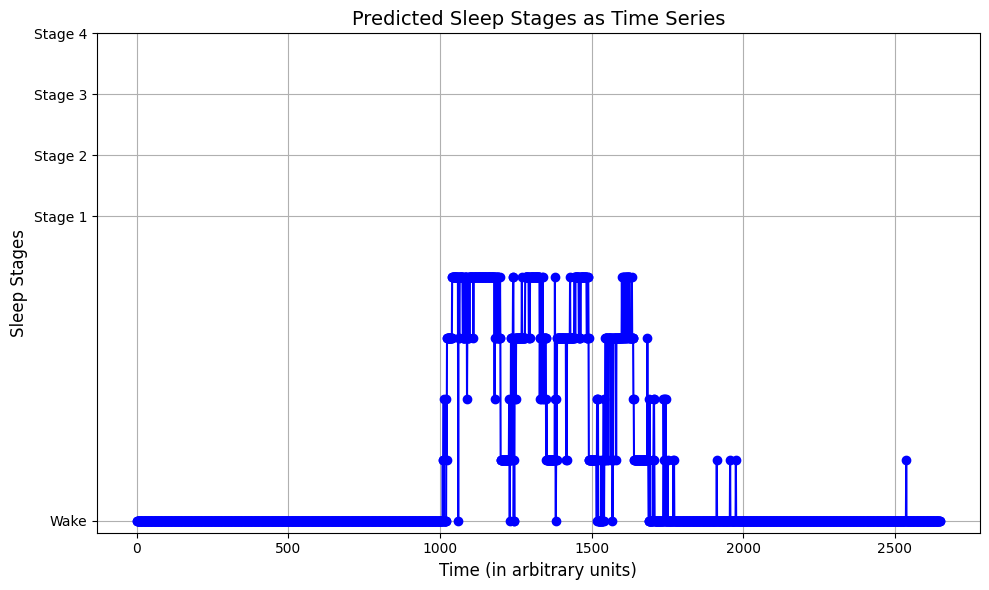

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

time_points = np.arange(len(predicted_stages))  # Create a time index for each predicted stage

# Create a time series plot
plt.figure(figsize=(10, 6))
plt.plot(time_points, predicted_stages, marker='o', linestyle='-', color='b')

# Adding title and labels
plt.title('Predicted Sleep Stages as Time Series', fontsize=14)
plt.xlabel('Time (in arbitrary units)', fontsize=12)
plt.ylabel('Sleep Stages', fontsize=12)

# Set y-ticks to represent the sleep stages
plt.yticks(['Wake', 'Stage 1', 'Stage 2', 'Stage 3', 'Stage 4'])

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


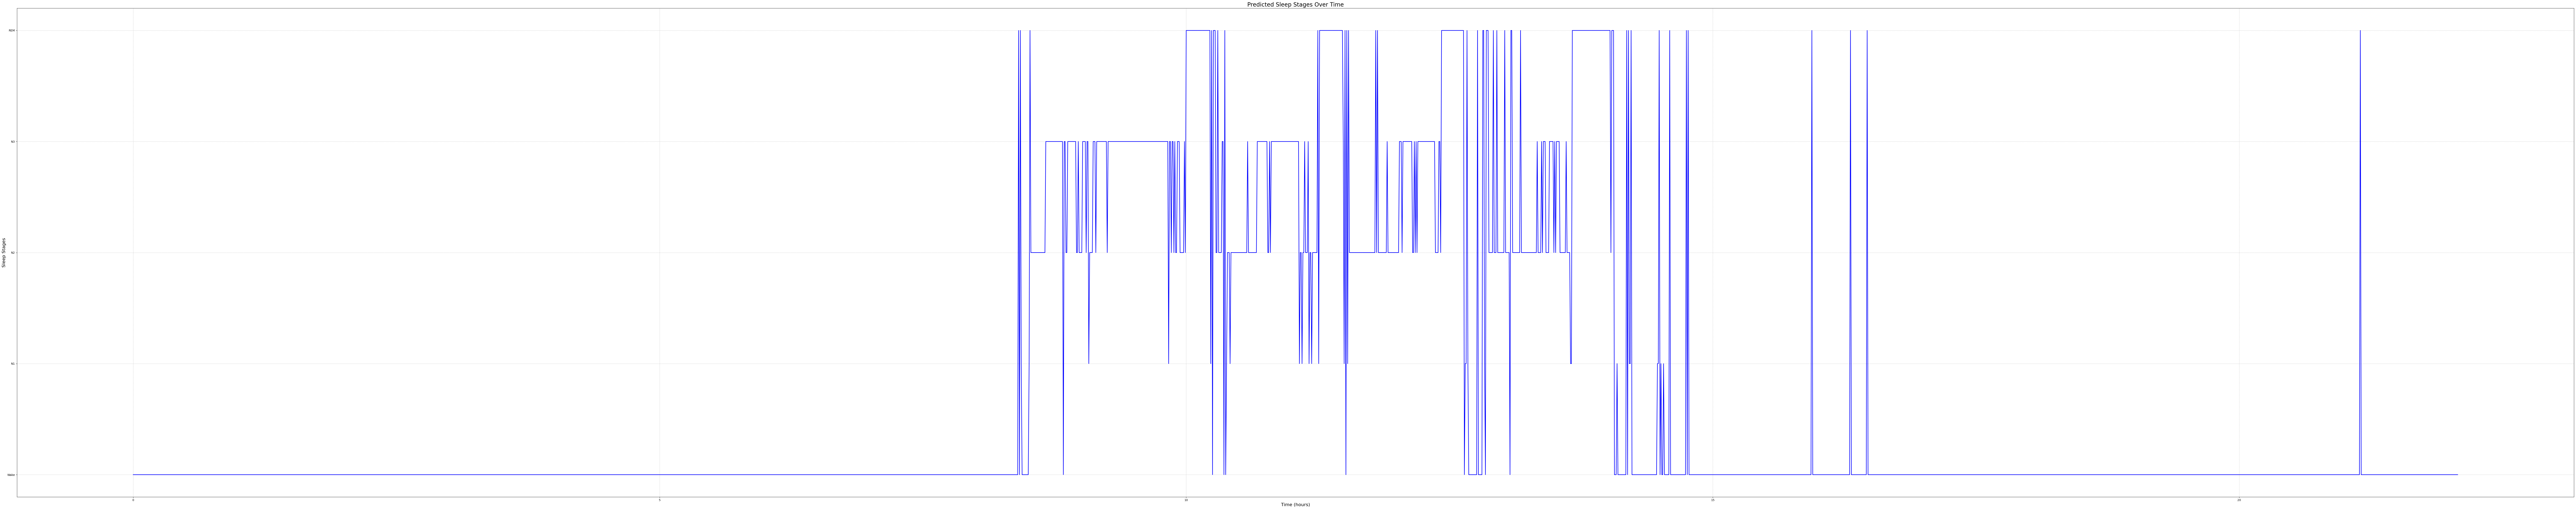

In [11]:

import matplotlib.pyplot as plt
import numpy as np


# Map each sleep stage to a unique numeric value for plotting
stage_mapping = {'Wake': 0, 'N1': 1, 'N2': 2, 'N3': 3, 'REM': 4}
numeric_stages = np.array([stage_mapping[stage] for stage in predicted_stages])

# Create time points in hours (30-second epochs converted to hours)
time_points = np.arange(len(predicted_stages)) * 30 / 3600  # Convert seconds to hours

# Create the plot
plt.figure(figsize=(126, 25))

# Plot the continuous line for all stages
plt.plot(time_points, numeric_stages, color='blue', linewidth=2)

# Adding title and labels
plt.title('Predicted Sleep Stages Over Time', fontsize=20)
plt.xlabel('Time (hours)', fontsize=16)
plt.ylabel('Sleep Stages', fontsize=16)

# Set y-ticks to show the stage names instead of numeric values
plt.yticks(list(stage_mapping.values()), list(stage_mapping.keys()))

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Optimize layout and show the plot
plt.tight_layout()
plt.show()


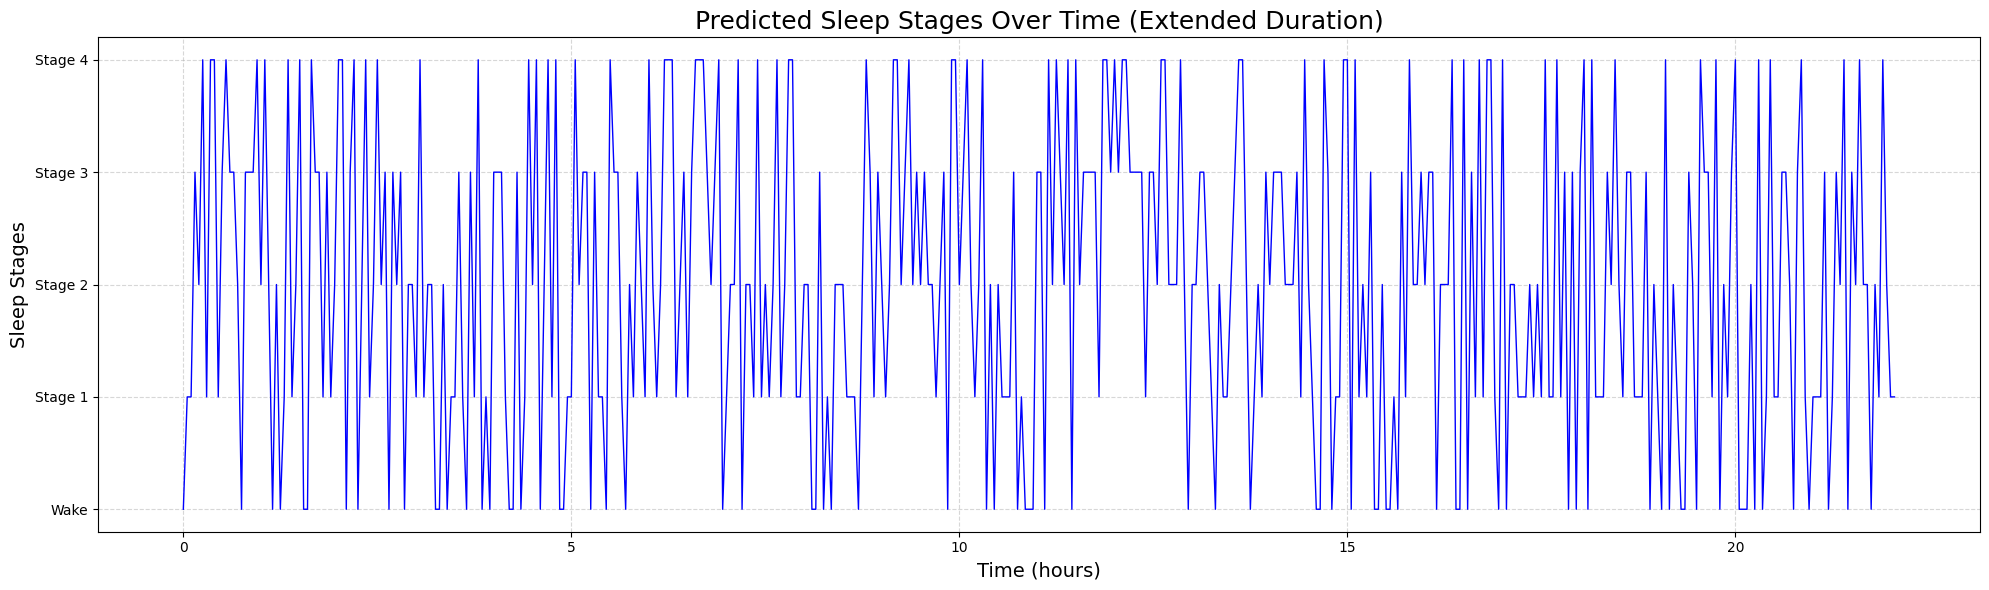

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated data or load actual data
# Replace this with your real dataset if available


# Map each sleep stage to a unique numeric value
stage_mapping = {'Wake': 0, 'Stage 1': 1, 'Stage 2': 2, 'Stage 3': 3, 'Stage 4': 4}
numeric_stages = np.array([stage_mapping[stage] for stage in predicted_stages])

# Create time points in hours
time_points = np.arange(len(predicted_stages)) * 30 / 3600  # Assuming 30-second epochs

# Downsample the data for longer time plots (optional)
downsample_factor = 6# Adjust as needed
time_points = time_points[::downsample_factor]
numeric_stages = numeric_stages[::downsample_factor]

# Plot the continuous line
plt.figure(figsize=(20, 6))  # Adjust the figure size for better clarity
plt.plot(time_points, numeric_stages, color='blue', linewidth=1)

# Adding title and labels
plt.title('Predicted Sleep Stages Over Time (Extended Duration)', fontsize=18)
plt.xlabel('Time (hours)', fontsize=14)
plt.ylabel('Sleep Stages', fontsize=14)

# Set y-ticks to show the stage names
plt.yticks(list(stage_mapping.values()), list(stage_mapping.keys()))

# Add grid for readability
plt.grid(True, linestyle='--', alpha=0.5)

# Optimize layout and show the plot
plt.tight_layout()
plt.show()


In [6]:

file_path = 'SC4002E0-PSG.edf'  # Replace with your actual file path

# Preprocess the .edf file
try:
    eeg_data, labels = load_and_preprocess_data(1)

    # Initialize the scaler
    scaler = StandardScaler()

    # Reshape the EEG data (flattening channels and time points for scaling)
    eeg_data_reshaped = eeg_data.reshape(eeg_data.shape[0], -1)  # Flatten the data (channels * time_points)

    # Fit and scale the training data
    eeg_data_scaled = scaler.fit_transform(eeg_data_reshaped)  # Apply scaling to training data

    # For prediction (use the same scaler for the test data)
    X_test_scaled = scaler.transform(eeg_data_reshaped)  # Apply scaling for test data (if it's separate)
    X_test_scaled = np.transpose(X_test_scaled, (0, 2, 1))  # Ensure correct shape for the model

    # Check if eeg_data is not None and then predict the sleep stages
    if eeg_data is not None:
        print("Preprocessing completed. Predicting sleep stages...")

        # Predict sleep stages using your model
        predictions = predict_sleep_stages(eeg_data, model)

        # Map numeric predictions to sleep stage names
        stage_map = {0: "Wake", 1: "N1", 2: "N2", 3: "N3", 4: "REM"}
        predicted_stages = [stage_map[stage] for stage in predictions]

        # Display predicted sleep stages
        print("Predicted Sleep Stages:", predicted_stages)

except Exception as e:
    print(f"An error occurred during processing: {e}")



Using default location ~/mne_data for PHYSIONET_SLEEP...
Creating /root/mne_data


100%|█████████████████████████████████████| 48.3M/48.3M [00:00<00:00, 36.8GB/s]
100%|█████████████████████████████████████| 4.62k/4.62k [00:00<00:00, 2.13MB/s]

Download complete in 01m23s (46.1 MB)
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



<ipython-input-4-195bc43c159e>:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(files[0][0], preload=True)
<ipython-input-4-195bc43c159e>:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(files[0][0], preload=True)
<ipython-input-4-195bc43c159e>:16: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(files[0][0], preload=True)


Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 661 samples (6.610 s)



<ipython-input-4-195bc43c159e>:19: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annots)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
2650 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2650 events and 3000 original time points ...
0 bad epochs dropped
An error occurred during processing: axes don't match array


In [7]:
#
print("Raw EEG Data Shape:", eeg_data.shape)

# Apply scaling while preserving the 3D structure of the data
scaler = StandardScaler()

# Reshape to (samples, channels * time_points) for scaling, then restore the 3D shape
eeg_data_reshaped = eeg_data.reshape(eeg_data.shape[0], -1)
print("Reshaped EEG Data for Scaling:", eeg_data_reshaped.shape)

eeg_data_scaled_reshaped = scaler.fit_transform(eeg_data_reshaped)
print("Scaled EEG Data Shape (reshaped):", eeg_data_scaled_reshaped.shape)


eeg_data_scaled = eeg_data_scaled_reshaped.reshape(eeg_data.shape[0], eeg_data.shape[1], eeg_data.shape[2])
print("Reshaped Scaled EEG Data back to 3D:", eeg_data_scaled.shape)


print("Transposed Scaled EEG Data Shape:", eeg_data_scaled.shape)


predictions = predict_sleep_stages(eeg_data_scaled, model)


Raw EEG Data Shape: (2650, 7, 3000)
Reshaped EEG Data for Scaling: (2650, 21000)
Scaled EEG Data Shape (reshaped): (2650, 21000)
Reshaped Scaled EEG Data back to 3D: (2650, 7, 3000)
Transposed Scaled EEG Data Shape: (2650, 7, 3000)
Entered into model prediction function
Data shape after transpose: (2650, 3000, 7)
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step
